In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
df1 = pd.read_csv("api_data_aadhar_enrolment_0_500000.csv")
df2 = pd.read_csv("api_data_aadhar_enrolment_500000_1000000.csv")
df3 = pd.read_csv("api_data_aadhar_enrolment_1000000_1006029.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

print(df.shape)
df.head()

(925737, 7)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121.0,11.0,61.0,37.0
1,09-03-2025,Karnataka,Bengaluru Urban,560043.0,14.0,33.0,39.0
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001.0,29.0,82.0,12.0
3,09-03-2025,Uttar Pradesh,Aligarh,202133.0,62.0,29.0,15.0
4,09-03-2025,Karnataka,Bengaluru Urban,560016.0,14.0,16.0,21.0


In [35]:
sorted(df['state'].unique())

['100000',
 'Andaman & Nicobar Islands',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra & Nagar Haveli',
 'Dadra and Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Daman and Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu & Kashmir',
 'Jammu And Kashmir',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'ODISHA',
 'Odisha',
 'Orissa',
 'Pondicherry',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'The Dadra And Nagar Haveli And Daman And Diu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'WEST BENGAL',
 'WESTBENGAL',
 'West  Bengal',
 'West Bangal',
 'West Bengal',
 'West bengal',
 'Westbengal',
 'andhra pradesh']

## DATA CLEANING

In [36]:
def normalize_state_name(state):
    if pd.isna(state):
        return state

    state = str(state).strip()
    state = state.lower()
    state = state.replace('&', 'and')
    state = ' '.join(state.split())  # remove extra spaces
    return state

In [37]:
state_mapping = {
    # Andaman & Nicobar
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',

    # Andhra Pradesh
    'andhra pradesh': 'Andhra Pradesh',

    # Dadra & Nagar Haveli / Daman & Diu
    'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'the dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',

    # Jammu & Kashmir
    'jammu and kashmir': 'Jammu and Kashmir',
    'jammu and kashmir ': 'Jammu and Kashmir',

    # Odisha
    'orissa': 'Odisha',
    'odisha': 'Odisha',

    # Puducherry
    'pondicherry': 'Puducherry',

    # West Bengal
    'west bengal': 'West Bengal',
    'west bengal ': 'West Bengal',
    'westbengal': 'West Bengal',
    'west bangal': 'West Bengal',

    # Delhi
    'delhi': 'Delhi'
}

In [38]:
df['state_clean'] = df['state'].apply(normalize_state_name)
df['state_clean'] = df['state_clean'].replace(state_mapping)

In [39]:
df = df[df['state_clean'] != '100000']

In [40]:
df['state_clean'] = df['state_clean'].str.title()

In [41]:
sorted(df['state_clean'].unique())

['Andaman And Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra And Nagar Haveli And Daman And Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu And Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

In [42]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 925720 entries, 0 to 925736
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            925720 non-null  object 
 1   state           925720 non-null  object 
 2   district        925720 non-null  object 
 3   pincode         925719 non-null  float64
 4   age_0_5         925719 non-null  float64
 5   age_5_17        925719 non-null  float64
 6   age_18_greater  925718 non-null  float64
 7   state_clean     925720 non-null  object 
dtypes: float64(4), object(4)
memory usage: 63.6+ MB


,pincode,age_0_5,age_5_17,age_18_greater
count,925719.000000,925719.000000,925719.000000,925718.000000
mean,518008.758431,3.609580,1.750042,0.175240
std,205638.506814,18.240982,14.949746,3.340976
min,110001.000000,0.000000,0.000000,0.000000
25%,363423.000000,1.000000,0.000000,0.000000
50%,517236.000000,2.000000,0.000000,0.000000
75%,700075.000000,3.000000,1.000000,0.000000
max,855456.000000,2688.000000,1812.000000,855.000000


In [43]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

In [44]:
df['total_enrolments'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

df['child_enrolments'] = df['age_0_5'] + df['age_5_17']
df['adult_enrolments'] = df['age_18_greater']

df['child_ratio'] = df['child_enrolments'] / df['total_enrolments']
df['adult_ratio'] = df['adult_enrolments'] / df['total_enrolments']

In [45]:
state_df = (
    df.groupby('state')
    .agg({
        'total_enrolments': 'sum',
        'child_enrolments': 'sum',
        'adult_enrolments': 'sum'
    })
    .reset_index()
)

state_df['child_ratio'] = state_df['child_enrolments'] / state_df['total_enrolments']
state_df['adult_ratio'] = state_df['adult_enrolments'] / state_df['total_enrolments']

state_df.head()

,state,total_enrolments,child_enrolments,adult_enrolments,child_ratio,adult_ratio
0,Andaman & Nicobar Islands,30.0,30.0,0.0,1.000000,0.000000
1,Andaman and Nicobar Islands,143.0,143.0,0.0,1.000000,0.000000
2,Andhra Pradesh,41947.0,41215.0,732.0,0.982549,0.017451
3,Arunachal Pradesh,2027.0,1972.0,55.0,0.972866,0.027134
4,Assam,145039.0,129072.0,15967.0,0.889912,0.110088


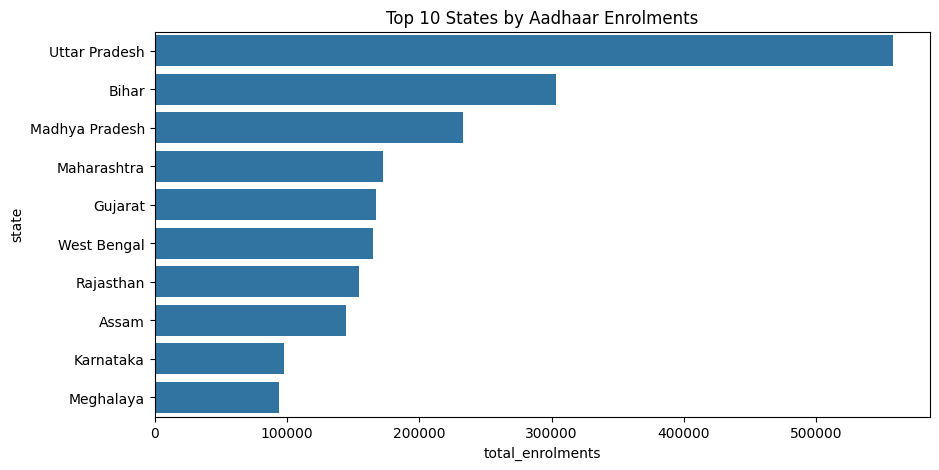

In [46]:
top_states = state_df.sort_values('total_enrolments', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top_states, y='state', x='total_enrolments')
plt.title("Top 10 States by Aadhaar Enrolments")
plt.show()

In [47]:
import pandas as pd
import numpy as np

In [48]:
demo_files = [
    "/content/api_data_aadhar_demographic_0_500000.csv",
    "/content/api_data_aadhar_demographic_500000_1000000.csv",
    "/content/api_data_aadhar_demographic_1000000_1500000.csv",
    "/content/api_data_aadhar_demographic_1500000_2000000.csv",
    "/content/api_data_aadhar_demographic_2000000_2071700.csv"
]

demo_df = pd.concat(
    [pd.read_csv(f) for f in demo_files],
    ignore_index=True
)

demo_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [49]:
bio_files = [
    "/content/api_data_aadhar_biometric_0_500000.csv",
    "/content/api_data_aadhar_biometric_500000_1000000.csv",
    "/content/api_data_aadhar_biometric_1000000_1500000.csv",
    "/content/api_data_aadhar_biometric_1500000_1861108.csv"
]

bio_df = pd.concat(
    [pd.read_csv(f) for f in bio_files],
    ignore_index=True
)

bio_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [50]:
def standardize_columns(df):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
    )
    return df

demo_df = standardize_columns(demo_df)
bio_df = standardize_columns(bio_df)

In [51]:
print(demo_df.columns)
print(bio_df.columns)

Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_'],
      dtype='object')
Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')


In [52]:
def construct_date(df):
    # The 'date' column already exists and contains the full date string.
    # We can directly convert it to datetime objects.
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    return df

demo_df = construct_date(demo_df)
bio_df = construct_date(bio_df)

In [53]:
def normalize_state(x):
    if pd.isna(x):
        return np.nan
    return (
        str(x)
        .lower()
        .strip()
        .replace('&', 'and')
    )

In [54]:
demo_df['state_clean'] = demo_df['state'].apply(normalize_state)
bio_df['state_clean'] = bio_df['state'].apply(normalize_state)

In [55]:
state_mapping = {
    'orissa': 'odisha',
    'jammu and kashmir': 'jammu and kashmir',
    'uttaranchal': 'uttarakhand',
    'chhatisgarh': 'chhattisgarh',
    'west bengal': 'west bengal',
    'westbengal': 'west bengal',
    'west  bengal': 'west bengal',
    'andhra pradesh': 'andhra pradesh',
    'dadra and nagar haveli':
        'dadra and nagar haveli and daman and diu',
    'daman and diu':
        'dadra and nagar haveli and daman and diu',
    'pondicherry': 'puducherry',
    'tamilnadu': 'tamil Nadu',
    'west bangal': 'west bengal'
}

In [56]:
demo_df['state_clean'] = demo_df['state_clean'].replace(state_mapping)
bio_df['state_clean'] = bio_df['state_clean'].replace(state_mapping)

demo_df['state_clean'] = demo_df['state_clean'].str.title()
bio_df['state_clean'] = bio_df['state_clean'].str.title()

In [57]:
def remove_junk_states(df):
    return df[
        (~df['state_clean'].str.isnumeric()) &
        (df['state_clean'].str.len() > 3)
    ]

demo_df = remove_junk_states(demo_df)
bio_df = remove_junk_states(bio_df)

In [58]:
sorted(demo_df['state_clean'].unique())
sorted(bio_df['state_clean'].unique())

['Andaman And Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra And Nagar Haveli And Daman And Diu',
 'Delhi',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu And Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

In [59]:
demo_update_cols = [
    col for col in demo_df.columns
    if col not in ['state', 'state_clean', 'year', 'month', 'date']
]
demo_update_cols

['district', 'pincode', 'demo_age_5_17', 'demo_age_17_']

In [60]:
bio_update_cols = [
    col for col in bio_df.columns
    if col not in ['state', 'state_clean', 'year', 'month', 'date']
]
bio_update_cols

['district', 'pincode', 'bio_age_5_17', 'bio_age_17_']

In [61]:
# identify demographic update columns
demo_update_cols = ['demo_age_5_17', 'demo_age_17_']

# state-wise total demographic updates
demo_state_updates = (
    demo_df
    .groupby('state_clean')[demo_update_cols]
    .sum()
    .sum(axis=1) # Sum across the age-group columns to get a total per state
    .reset_index(name='demographic_updates')
)

demo_state_updates.sort_values(
    'demographic_updates', ascending=False
).head(10)

,state_clean,demographic_updates
39,Uttar Pradesh,8542328
23,Maharashtra,5054602
5,Bihar,4814350
41,West Bengal,3872734
22,Madhya Pradesh,2912938
34,Rajasthan,2817615
1,Andhra Pradesh,2295582
36,Tamil Nadu,2212228
7,Chhattisgarh,2005438
11,Gujarat,1824327


,state_clean,demographic_updates
39,Uttar Pradesh,8542328
23,Maharashtra,5054602
5,Bihar,4814350
41,West Bengal,3872734
22,Madhya Pradesh,2912938
34,Rajasthan,2817615
1,Andhra Pradesh,2295582
36,Tamil Nadu,2212228
7,Chhattisgarh,2005438
11,Gujarat,1824327


In [62]:
# identify biometric update columns
bio_update_cols = ['bio_age_5_17', 'bio_age_17_']

# state-wise total biometric updates
bio_state_updates = (
    bio_df
    .groupby('state_clean')[bio_update_cols]
    .sum()
    .sum(axis=1) # Sum across the age-group columns to get a total per state
    .reset_index(name='biometric_updates')
)

bio_state_updates.sort_values(
    'biometric_updates', ascending=False
).head(10)

,state_clean,biometric_updates
32,Uttar Pradesh,9577735
19,Maharashtra,9226139
18,Madhya Pradesh,5923771
4,Bihar,4897587
29,Tamil Nadu,4698118
27,Rajasthan,3994955
1,Andhra Pradesh,3714633
9,Gujarat,3196514
6,Chhattisgarh,2648734
14,Karnataka,2635954


#### COMMON UPDATE PATTERN (KEY STEP)

In [63]:
common_updates = pd.merge(
    demo_state_updates,
    bio_state_updates,
    on='state_clean',
    how='outer'
).fillna(0)

common_updates['total_updates'] = (
    common_updates['demographic_updates'] +
    common_updates['biometric_updates']
)

common_updates.sort_values(
    'total_updates', ascending=False
).head(10)

,state_clean,demographic_updates,biometric_updates,total_updates
39,Uttar Pradesh,8542328,9577735.0,18120063.0
23,Maharashtra,5054602,9226139.0,14280741.0
5,Bihar,4814350,4897587.0,9711937.0
22,Madhya Pradesh,2912938,5923771.0,8836709.0
36,Tamil Nadu,2212228,4698118.0,6910346.0
34,Rajasthan,2817615,3994955.0,6812570.0
41,West Bengal,3872734,2524619.0,6397353.0
1,Andhra Pradesh,2295582,3714633.0,6010215.0
11,Gujarat,1824327,3196514.0,5020841.0
7,Chhattisgarh,2005438,2648734.0,4654172.0


#### BAR GRAPH — STATE VS TOTAL UPDATES

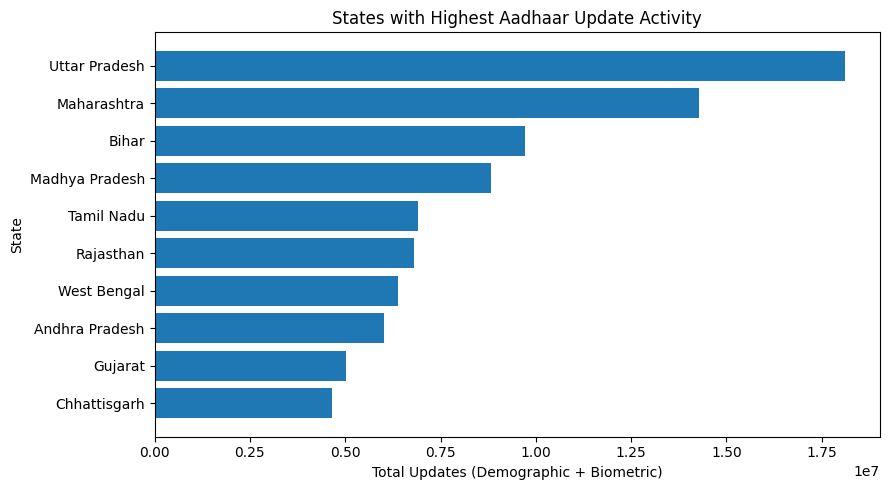

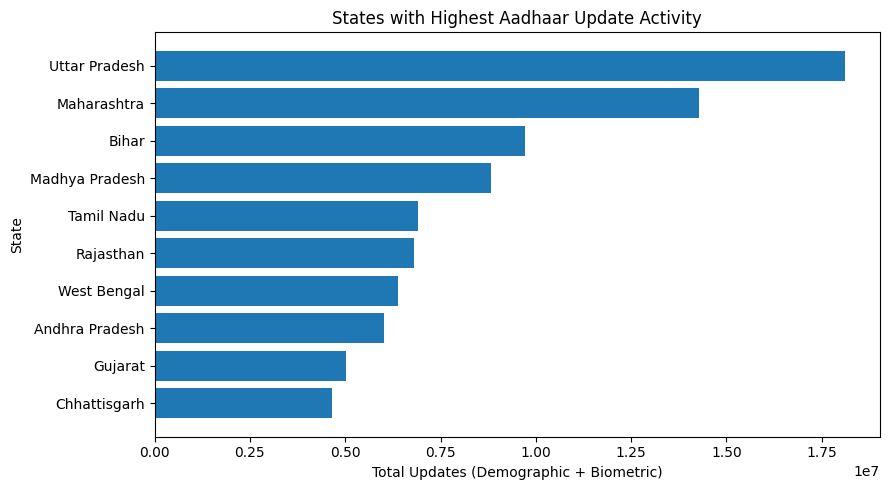

In [64]:
import matplotlib.pyplot as plt

top_states = common_updates.sort_values(
    'total_updates', ascending=False
).head(10)

plt.figure(figsize=(9,5))
plt.barh(
    top_states['state_clean'],
    top_states['total_updates']
)
plt.xlabel("Total Updates (Demographic + Biometric)")
plt.ylabel("State")
plt.title("States with Highest Aadhaar Update Activity")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [65]:
common_updates.describe()

,demographic_updates,biometric_updates,total_updates
count,4.300000e+01,4.300000e+01,4.300000e+01
mean,1.145583e+06,1.620807e+06,2.766390e+06
std,1.754284e+06,2.345733e+06,4.035586e+06
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.725000e+03,2.175900e+04,3.555200e+04
50%,3.015490e+05,3.962340e+05,5.841360e+05
75%,1.662596e+06,2.494790e+06,3.954132e+06
max,8.542328e+06,9.577735e+06,1.812006e+07


####compare

In [66]:
# state-wise total enrolments
state_enrolments = (
    df
    .groupby('state_clean')['total_enrolments'] # Directly select the column and sum it
    .sum()
    .reset_index(name='total_enrolments')
)

state_enrolments.sort_values(
    'total_enrolments', ascending=False
).head(10)

,state_clean,total_enrolments
33,Uttar Pradesh,557687.0
4,Bihar,302969.0
19,Madhya Pradesh,232899.0
20,Maharashtra,172465.0
10,Gujarat,167099.0
35,West Bengal,164867.0
28,Rajasthan,154860.0
3,Assam,145039.0
15,Karnataka,97668.0
22,Meghalaya,94116.0


####MERGE UPDATES WITH ENROLMENT

In [67]:
state_compare = pd.merge(
    common_updates,
    state_enrolments,
    on='state_clean',
    how='left'
)

state_compare.head()

,state_clean,demographic_updates,biometric_updates,total_updates,total_enrolments
0,Andaman And Nicobar Islands,7246,20698.0,27944.0,173.0
1,Andhra Pradesh,2295582,3714633.0,6010215.0,41948.0
2,Arunachal Pradesh,36443,72394.0,108837.0,2027.0
3,Assam,1012578,982722.0,1995300.0,145039.0
4,Balanagar,2,0.0,2.0,NaN


In [68]:
state_compare['update_enrolment_ratio'] = (
    state_compare['total_updates'] /
    state_compare['total_enrolments']
)

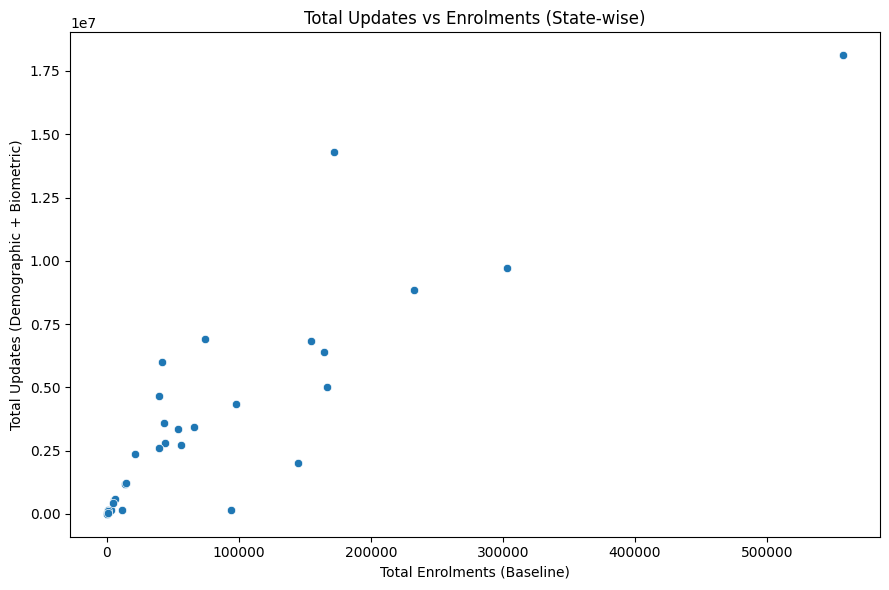

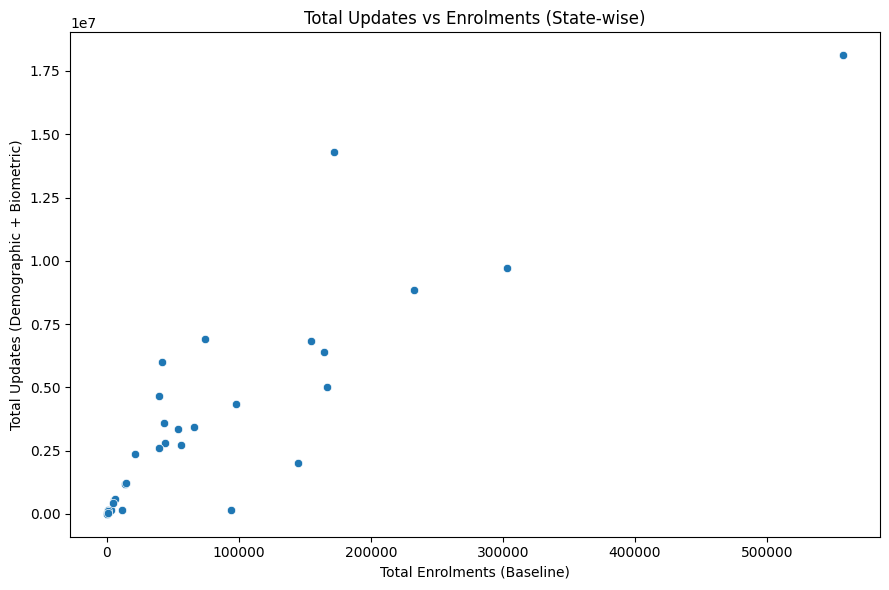

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=state_compare,
    x='total_enrolments',
    y='total_updates'
)
plt.xlabel("Total Enrolments (Baseline)")
plt.ylabel("Total Updates (Demographic + Biometric)")
plt.title("Total Updates vs Enrolments (State-wise)")
plt.tight_layout()
plt.show()

In [70]:
state_compare.sort_values(
    'update_enrolment_ratio', ascending=False
).head(10)

,state_clean,demographic_updates,biometric_updates,total_updates,total_enrolments,update_enrolment_ratio
6,Chandigarh,83361,74482.0,157843.0,890.0,177.351685
0,Andaman And Nicobar Islands,7246,20698.0,27944.0,173.0,161.526012
1,Andhra Pradesh,2295582,3714633.0,6010215.0,41948.0,143.277749
7,Chhattisgarh,2005438,2648734.0,4654172.0,39731.0,117.142080
18,Kerala,744952,1609730.0,2354682.0,21678.0,108.620814
13,Himachal Pradesh,149214,396234.0,545448.0,5114.0,106.657802
36,Tamil Nadu,2212228,4698118.0,6910346.0,74674.0,92.540188
38,Tripura,138013,292155.0,430168.0,4682.0,91.876976
24,Manipur,301549,282587.0,584136.0,6517.0,89.632653
20,Lakshadweep,1176,4820.0,5996.0,67.0,89.492537


In [71]:
top_states_split = (
    common_updates
    .sort_values('total_updates', ascending=False)
    .head(10)
)

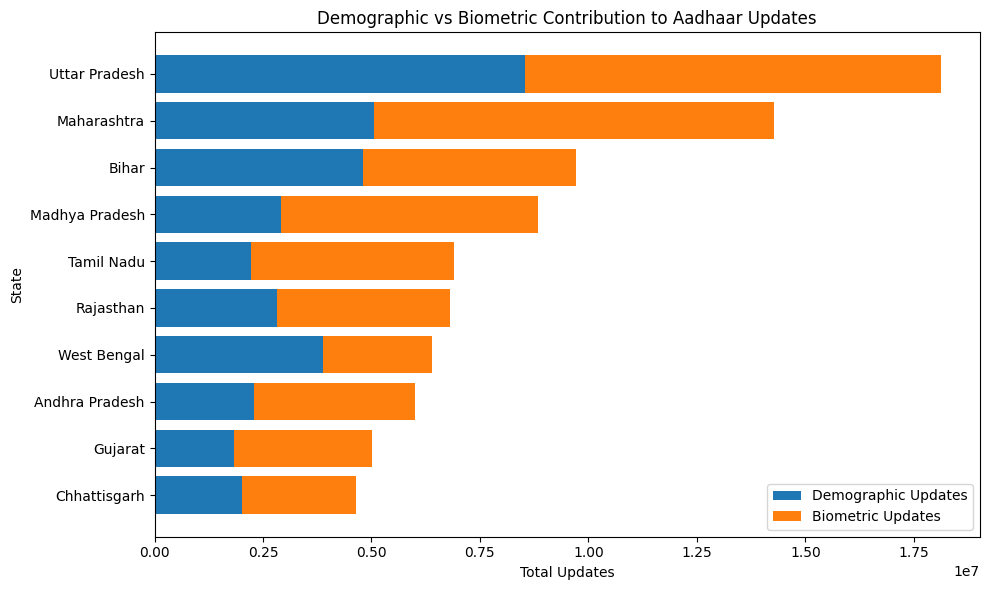

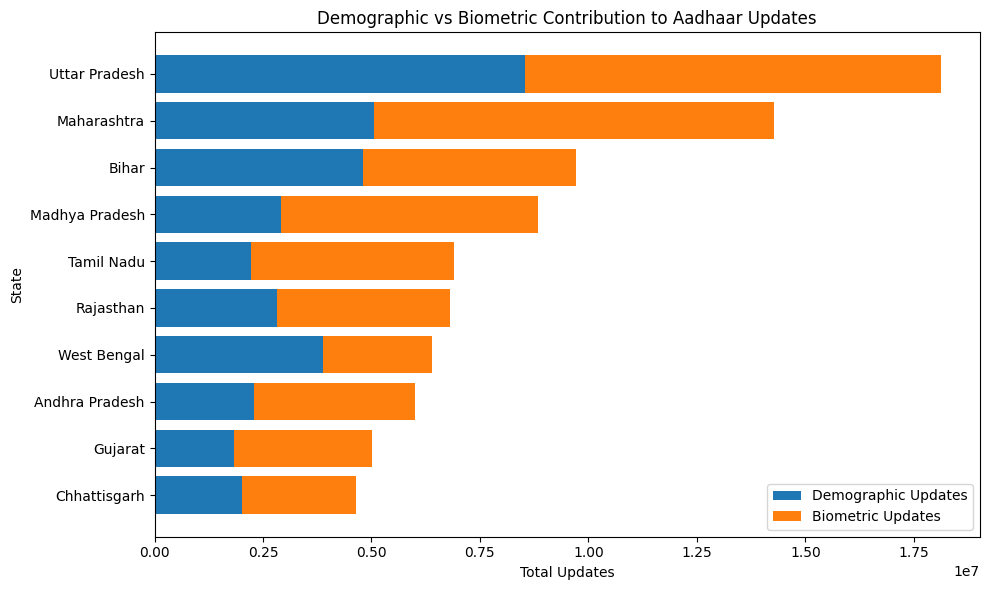

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.barh(
    top_states_split['state_clean'],
    top_states_split['demographic_updates'],
    label='Demographic Updates'
)

plt.barh(
    top_states_split['state_clean'],
    top_states_split['biometric_updates'],
    left=top_states_split['demographic_updates'],
    label='Biometric Updates'
)

plt.xlabel("Total Updates")
plt.ylabel("State")
plt.title("Demographic vs Biometric Contribution to Aadhaar Updates")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [73]:
state_compare['update_enrolment_ratio'] = (
    state_compare['total_updates'] /
    state_compare['total_enrolments']
)

In [74]:
top_ratio_states = (
    state_compare
    .sort_values('update_enrolment_ratio', ascending=False)
    .head(10)
)

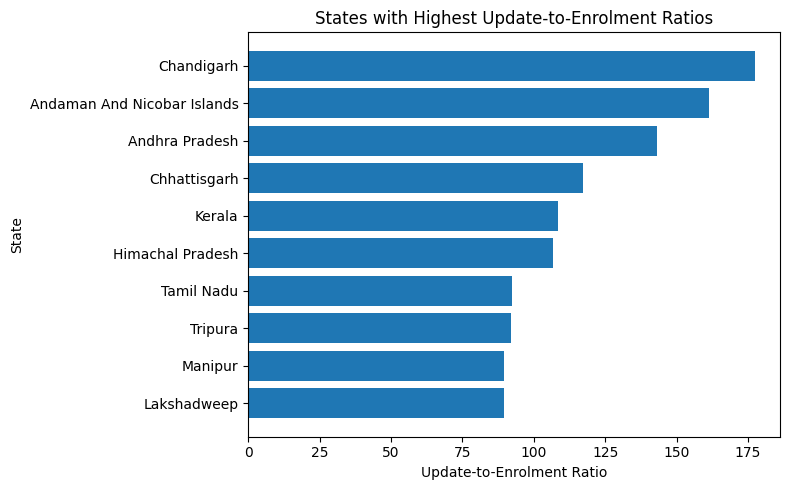

In [75]:
plt.figure(figsize=(8,5))

plt.barh(
    top_ratio_states['state_clean'],
    top_ratio_states['update_enrolment_ratio']
)

plt.xlabel("Update-to-Enrolment Ratio")
plt.ylabel("State")
plt.title("States with Highest Update-to-Enrolment Ratios")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### visual 1

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

start_date = pd.to_datetime("2025-01-01")
end_date   = pd.to_datetime("2025-12-31")

In [77]:
enrol_f = df[
    (df['date'] >= start_date) &
    (df['date'] <= end_date)
]

In [78]:
demo_f = demo_df[
    (demo_df['date'] >= start_date) &
    (demo_df['date'] <= end_date)
]

In [79]:
bio_f = bio_df[
    (bio_df['date'] >= start_date) &
    (bio_df['date'] <= end_date)
]

In [82]:
enrolment_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
monthly_enrol = (
    enrol_f
    .groupby('date')[enrolment_cols]
    .sum()
    .sum(axis=1)
    .reset_index(name='total_enrolments')
)

####ISOLATION FOREST

In [89]:
state_compare

,state_clean,demographic_updates,biometric_updates,total_updates,total_enrolments,update_enrolment_ratio
0,Andaman And Nicobar Islands,7246,20698.0,27944.0,173.0,161.526012
1,Andhra Pradesh,2295582,3714633.0,6010215.0,41948.0,143.277749
2,Arunachal Pradesh,36443,72394.0,108837.0,2027.0,53.693636
3,Assam,1012578,982722.0,1995300.0,145039.0,13.756989
4,Balanagar,2,0.0,2.0,NaN,NaN
5,Bihar,4814350,4897587.0,9711937.0,302969.0,32.055877
6,Chandigarh,83361,74482.0,157843.0,890.0,177.351685
7,Chhattisgarh,2005438,2648734.0,4654172.0,39731.0,117.142080
8,Dadra And Nagar Haveli And Daman And Diu,12204,39268.0,51472.0,1074.0,47.925512
9,Darbhanga,2,0.0,2.0,NaN,NaN


In [90]:
state_compare.head()

,state_clean,demographic_updates,biometric_updates,total_updates,total_enrolments,update_enrolment_ratio
0,Andaman And Nicobar Islands,7246,20698.0,27944.0,173.0,161.526012
1,Andhra Pradesh,2295582,3714633.0,6010215.0,41948.0,143.277749
2,Arunachal Pradesh,36443,72394.0,108837.0,2027.0,53.693636
3,Assam,1012578,982722.0,1995300.0,145039.0,13.756989
4,Balanagar,2,0.0,2.0,NaN,NaN


In [91]:
ml_features = state_compare[[
    'total_enrolments',
    'demographic_updates',
    'biometric_updates',
    'update_enrolment_ratio'
]].fillna(0)

In [92]:
from sklearn.ensemble import IsolationForest

In [93]:
iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.15,   # ~15% states expected to be abnormal
    random_state=42
)

In [94]:
ml_features['anomaly_flag'] = iso_model.fit_predict(ml_features)
state_compare['anomaly_flag'] = ml_features['anomaly_flag']

In [95]:
state_compare[['state_clean', 'update_enrolment_ratio', 'anomaly_flag']] \
    .sort_values('update_enrolment_ratio', ascending=False)

,state_clean,update_enrolment_ratio,anomaly_flag
6,Chandigarh,177.351685,1
0,Andaman And Nicobar Islands,161.526012,1
1,Andhra Pradesh,143.277749,-1
7,Chhattisgarh,117.142080,1
18,Kerala,108.620814,1
13,Himachal Pradesh,106.657802,1
36,Tamil Nadu,92.540188,1
38,Tripura,91.876976,1
24,Manipur,89.632653,1
20,Lakshadweep,89.492537,1


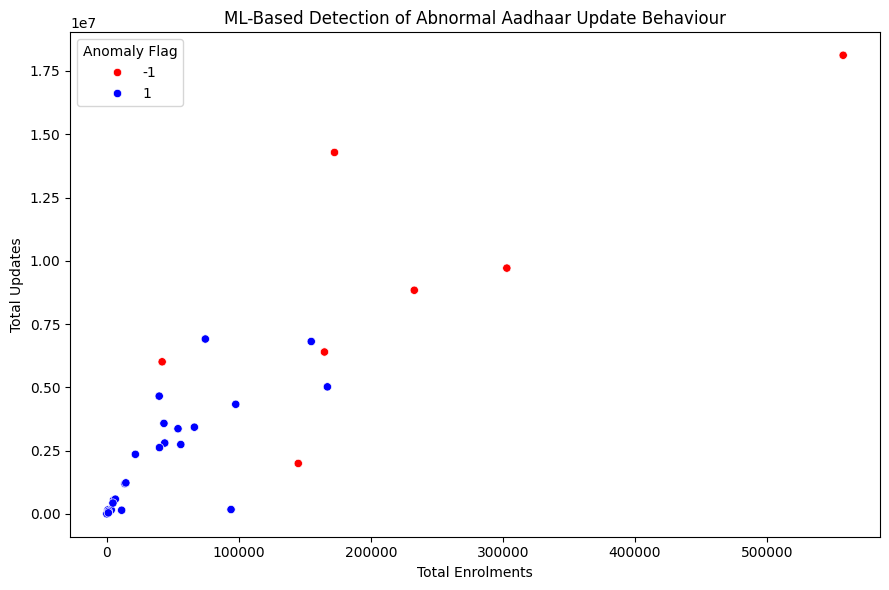

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=state_compare,
    x='total_enrolments',
    y='total_updates',
    hue='anomaly_flag',
    palette={1: 'blue', -1: 'red'}
)

plt.title("ML-Based Detection of Abnormal Aadhaar Update Behaviour")
plt.xlabel("Total Enrolments")
plt.ylabel("Total Updates")
plt.legend(title="Anomaly Flag")
plt.tight_layout()
plt.show()